# Bias-correct CESM2 LENS temperature data using ERA5 reanalysis

- This notebook illustrates how to bias-correct daily temperature data from CESM2 Large Ensemble Dataset (https://www.cesm.ucar.edu/community-projects/lens2) hosted on AWS.
- This data is open access (https://aws.amazon.com/marketplace/pp/prodview-xilranwbl2ep2#resources)
- We will access the data using OSDF's AWS open data origin.
- The OSDF zarr paths are obtained from an intake catalog which lives on NCAR's Research Data Archive and is publicly accessible via https.
- We will use NCAR's origin to access the publicly available ERA5 reanalysis.
- If you don't have access to NCAR's HPC system, please select the appropriate cluster
- All the intermediate results and the final result will be written to NCAR's GLADE storage system, which doesn't have public write access.
- You are welcome to modify this to suit your needs.
- In summary, this notebook illustrates how we can access data from two different OSDF origins and perform an interesting computation.

In [3]:
# Display output of plots directly in Notebook
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import intake
import numpy as np
import pandas as pd
import xarray as xr
# import s3fs
import seaborn as sns
import re
# import nest_asyncio
# nest_asyncio.apply()
import xesmf as xe
import matplotlib.pyplot as plt

In [4]:
import fsspec.implementations.http as fshttp
from pelicanfs.core import PelicanFileSystem, PelicanMap, OSDFFileSystem 

In [5]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [6]:
init_year0  = '1991'
init_year1  = '2020'
final_year0 = '2071'
final_year1 = '2100'

In [7]:
def to_daily(ds):
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time")

In [8]:
rda_scratch = '/gpfs/csfs1/collections/rda/scratch/harshah'
zarr_path   = rda_scratch + "/tas_zarr/"
mean_path   = zarr_path + "/means/"
stdev_path  = zarr_path + "/stdevs/"
#
rda_url        =  'https://data.rda.ucar.edu/'
intake_url     = rda_url + 'harshah/intake_catalogs/cesm2-lens-osdf/aws-cesm2-le.json'

### Create a Dask cluster
#### Dask Introduction

Dask is a solution that enables the scaling of Python libraries. It mimics popular scientific libraries such as numpy, pandas, and xarray that enables an easier path to parallel processing without having to refactor code.

There are 3 components to parallel processing with Dask: the client, the scheduler, and the workers.

The Client is best envisioned as the application that sends information to the Dask cluster. In Python applications this is handled when the client is defined with client = Client(CLUSTER_TYPE). A Dask cluster comprises of a single scheduler that manages the execution of tasks on workers. The CLUSTER_TYPE can be defined in a number of different ways.

- There is LocalCluster, a cluster running on the same hardware as the application and sharing the available resources, directly in Python with dask.distributed.

- In certain JupyterHubs Dask Gateway may be available and a dedicated dask cluster with its own resources can be created dynamically with dask.gateway.

- On HPC systems dask_jobqueue is used to connect to the HPC Slurm, PBS or HTCondor job schedulers to provision resources.

The dask.distributed client python module can also be used to connect to existing clusters. A Dask Scheduler and Workers can be deployed in containers, or on Kubernetes, without using a Python function to create a dask cluster. The dask.distributed Client is configured to connect to the scheduler either by container name, or by the Kubernetes service name.

### Select the Dask cluster type
The default will be LocalCluster as that can run on any system.

If running on a HPC computer with a PBS Scheduler, set to True. Otherwise, set to False.

In [9]:
USE_PBS_SCHEDULER = True

If running on Jupyter server with Dask Gateway configured, set to True. Otherwise, set to False.

In [10]:
USE_DASK_GATEWAY = False

#### Python function for a PBS cluster

In [11]:
# Create a PBS cluster object
def get_pbs_cluster():
    """ Create cluster through dask_jobqueue.   
    """
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(
        job_name = 'dask-osdf-24',
        cores = 1,
        memory = '4GiB',
        processes = 1,
        local_directory = rda_scratch + '/dask/spill',
        log_directory = rda_scratch + '/dask/logs/',
        resource_spec = 'select=1:ncpus=1:mem=4GB',
        queue = 'casper',
        walltime = '3:00:00',
        #interface = 'ib0'
        interface = 'ext'
    )
    return cluster

#### Python function for a Gateway Cluster

In [12]:
def get_gateway_cluster():
    """ Create cluster through dask_gateway
    """
    from dask_gateway import Gateway

    gateway = Gateway()
    cluster = gateway.new_cluster()
    cluster.adapt(minimum=2, maximum=4)
    return cluster

#### Python function for a Local Cluster

In [13]:
def get_local_cluster():
    """ Create cluster using the Jupyter server's resources
    """
    from distributed import LocalCluster, performance_report
    cluster = LocalCluster()    

    cluster.scale(4)
    return cluster

#### Python logic to select the Dask Cluster type

This uses True/False boolean logic based on the variables set in the previous cells

In [14]:
# Obtain dask cluster in one of three ways

if USE_PBS_SCHEDULER:
    cluster = get_pbs_cluster()
elif USE_DASK_GATEWAY:
    cluster = get_gateway_cluster()
else:
    cluster = get_local_cluster()

# Connect to cluster
from distributed import Client
client = Client(cluster)


In [15]:
# Scale the cluster and display cluster dashboard URL
cluster.scale(5)

cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.115:37531,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load CESM LENS2 temperature data using an intake catalog

In [16]:
cesm_cat = intake.open_esm_datastore(intake_url)
cesm_cat

,unique
Unnamed: 0,322
variable,53
long_name,51
component,4
experiment,2
forcing_variant,2
frequency,3
vertical_levels,3
spatial_domain,3
units,20


In [17]:
cesm_temp = cesm_cat.search(variable ='TREFHTMX', frequency ='daily')
cesm_temp

,unique
Unnamed: 0,4
variable,1
long_name,1
component,1
experiment,2
forcing_variant,2
frequency,1
vertical_levels,1
spatial_domain,1
units,1


In [18]:
cesm_temp.df['path'].values

array(['osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-TREFHTMX.zarr',
       'osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-smbb-TREFHTMX.zarr',
       'osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-ssp370-cmip6-TREFHTMX.zarr',
       'osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-ssp370-smbb-TREFHTMX.zarr'],
      dtype=object)

In [22]:
%%time
dsets_cesm = cesm_temp.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


ESMDataSourceError: Failed to load dataset with key='atm.ssp370.daily.cmip6'
                 You can use `cat['atm.ssp370.daily.cmip6'].df` to inspect the assets/files for this key.
                 

In [23]:
historical_smbb  = dsets_cesm['atm.historical.daily.smbb']
future_smbb      = dsets_cesm['atm.ssp370.daily.smbb']

historical_cmip6 = dsets_cesm['atm.historical.daily.cmip6']
future_cmip6     = dsets_cesm['atm.ssp370.daily.cmip6']

NameError: name 'dsets_cesm' is not defined

In [ ]:
historical_smbb_init = historical_smbb.TREFHTMX.sel(time=slice(init_year0, init_year1))
historical_smbb_init

In [ ]:
%%time
# Plot sample data
historical_smbb.TREFHTMX.isel(member_id=0,time=0).plot()

## Data Access Speed tests
- We will now test how long it takes to access data (via OSDF) for various sizes using one of the above arrays

In [60]:
# Test 0 : Single data point, Mem: 4 bytes. Takes 1 min 30s when .compute() is called on this data array (which loads data into memory)
historical_smbb_init0 = historical_smbb_init.isel(lat=0,lon=0,time=0,member_id=0)

In [61]:
#Test 1: Whole globe +all member_ids for 1 time step, Mem: 10.55 MiB ~ 10.55 MB
historical_smbb_init1 = historical_smbb_init.isel(time=0)
historical_smbb_init1

<xarray.DataArray 'TREFHTMX' (member_id: 50, lat: 192, lon: 288)> Size: 11MB
dask.array<getitem, shape=(50, 192, 288), dtype=float32, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1191p1f2' ... 'r9i1171p1f2'
    time       object 8B 1991-01-01 12:00:00
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [62]:
#Try using a specific cache

In [63]:
sdsc_cache='https://sdsc-cache.nationalresearchplatform.org:8443/aws-opendata/us-west-2/ncar-cesm2-lens/atm/monthly/cesm2LE-historical-smbb-TREFHTMX.zarr'

In [64]:
%%time
test_1 = xr.open_zarr(sdsc_cache).TREFHTMX.isel(time=0)
test_1

CPU times: user 31.7 ms, sys: 5.18 ms, total: 36.9 ms
Wall time: 421 ms


<xarray.DataArray 'TREFHTMX' (member_id: 50, lat: 192, lon: 288)> Size: 11MB
dask.array<getitem, shape=(50, 192, 288), dtype=float32, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1191p1f2' ... 'r9i1171p1f2'
    time       object 8B 1850-01-16 12:00:00
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [65]:
%%time
test_1.compute()

CPU times: user 12.4 s, sys: 4.87 s, total: 17.3 s
Wall time: 59.1 s


<xarray.DataArray 'TREFHTMX' (member_id: 50, lat: 192, lon: 288)> Size: 11MB
array([[[249.19678, 249.19678, 249.19678, ..., 249.19678, 249.19678,
         249.19678],
        [250.43887, 250.38249, 250.20448, ..., 250.51567, 250.49054,
         250.4645 ],
        [251.08882, 251.02448, 250.98175, ..., 251.38719, 251.31668,
         251.22348],
        ...,
        [252.86601, 252.86296, 252.86362, ..., 252.86687, 252.86418,
         252.86697],
        [253.20384, 253.19318, 253.18105, ..., 253.23492, 253.22736,
         253.21567],
        [253.72546, 253.72377, 253.72223, ..., 253.73227, 253.72937,
         253.72731]],

       [[250.03368, 250.03374, 250.03377, ..., 250.03348, 250.03358,
         250.03354],
        [251.50316, 251.46185, 251.30855, ..., 251.60414, 251.58113,
         251.54517],
        [251.80588, 251.75319, 251.708  , ..., 252.13205, 252.05107,
         251.94751],
...
        [268.4083 , 268.4154 , 268.42007, ..., 268.38837, 268.39636,
         268.4018 ],
        [267.8907 , 267.89398, 267.91336, ..., 267.87415, 267.8794 ,
         267.88562],
        [267.46216, 267.46402, 267.46616, ..., 267.4559 , 267.4582 ,
         267.46027]],

       [[251.26021, 251.26021, 251.26021, ..., 251.26021, 251.26021,
         251.26021],
        [252.20267, 252.15547, 251.99138, ..., 252.24664, 252.23686,
         252.22755],
        [252.2071 , 252.15166, 252.12477, ..., 252.44124, 252.40294,
         252.3248 ],
        ...,
        [255.79259, 255.81528, 255.84357, ..., 255.7705 , 255.77013,
         255.77153],
        [257.0061 , 257.0269 , 257.04892, ..., 256.95438, 256.97034,
         256.98737],
        [258.37668, 258.3746 , 258.3727 , ..., 258.38428, 258.38147,
         258.37894]]], dtype=float32)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1191p1f2' ... 'r9i1171p1f2'
    time       object 8B 1850-01-16 12:00:00
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [44]:
# Now, try to access the same array without specifying the cache

In [66]:
%%time
historical_smbb_init1.compute()

RuntimeError: error during blosc decompression: 0

In [ ]:
%%time
merge_ds_smbb = xr.concat([historical_smbb, future_smbb], dim='time')
merge_ds_smbb = merge_ds_smbb.dropna(dim='member_id')

merge_ds_cmip6= xr.concat([historical_cmip6, future_cmip6], dim='time')
merge_ds_cmip6 = merge_ds_cmip6.dropna(dim='member_id')

In [ ]:
t_smbb      = merge_ds_smbb.TREFHTMX
t_cmip6     = merge_ds_cmip6.TREFHTMX
t_init_cmip6 = t_cmip6.sel(time=slice(init_year0, init_year1))
t_init_smbb  = t_smbb.sel(time=slice(init_year0, init_year1))
t_init       = xr.concat([t_init_cmip6,t_init_smbb],dim='member_id')
t_init

In [ ]:
t_init_day = to_daily(t_init)
#t_init_day

In [ ]:
t_fut_cmip6 = t_cmip6.sel(time=slice(final_year0, final_year1))
t_fut_smbb  = t_smbb.sel(time=slice(final_year0, final_year1))
t_fut       = xr.concat([t_fut_cmip6,t_fut_smbb],dim='member_id')
t_fut_day   = to_daily(t_fut)
t_fut_day

### Save means and standard deviations

In [ ]:
# init_means   = t_init_day.mean({'year','member_id'})
# init_stdevs  = t_init_day.std({'year','member_id'})
# final_means  = t_fut_day.mean({'year','member_id'})
# final_stdevs = t_fut_day.std({'year','member_id'})
#
init_ensemble_means  = t_init_day.mean({'member_id'})
final_ensemble_means = t_fut_day.mean({'member_id'})
init_ensemble_means  = init_ensemble_means.chunk({'lat':192,'lon':288,'year':2,'day':365})
final_ensemble_means = final_ensemble_means.chunk({'lat':192,'lon':288,'year':2,'day':365})

- Save the overall means, standard devaitions and the ensemble means
- We will regrid the 'final/EOC' ensemble means onto the ERA5 grid.
- We will then compare it with the bias-corrected future predictions obtained from ERA5

In [ ]:
# %%time
# init_means.to_dataset().to_zarr(mean_path + 'cesm2_'+ init_year0 + '_' + init_year1+ '_means.zarr',mode='w')
# init_stdevs.to_dataset().to_zarr(stdev_path + 'cesm2_'+ init_year0 + '_' + init_year1+ '_stdevs.zarr',mode='w') 
# final_means.to_dataset().to_zarr(mean_path + 'cesm2_'+ final_year0 + '_' + final_year1+ '_means.zarr',mode='w')
# final_stdevs.to_dataset().to_zarr(stdev_path + 'cesm2_'+ final_year0 + '_' + final_year1+ '_stdevs.zarr',mode='w') 
# init_ensemble_means.to_dataset().to_zarr(mean_path + 'cesm2_'+ init_year0 + '_' + init_year1 \
#                                          + '_ensemble_means.zarr',mode='w')
# final_ensemble_means.to_dataset().to_zarr(mean_path + 'cesm2_'+ final_year0 + '_' + final_year1 \
#                                           + '_ensemble_means.zarr',mode='w')

## Access ERA5 data and regrid CESM2 LENS data on the finer, ERA5 grid

In [61]:
# Create OSDF file path for the ERA5 zarr store
namespace        = 'ncar/'   #NCAR's Research Data Archive
# osdf_director    = 'https://osdf-director.osg-htc.org/'
osdf_director    = 'osdf:///'
era5_zarr_path   = namespace + 'rda/harshah/era5_tas/zarr/e5_tas2m_daily_1940_2023.zarr'
#
# pelfs = PelicanFileSystem(osdf_director)
pelfs = OSDFFileSystem()
#
pel_zarr         = PelicanMap(era5_zarr_path, pelfs)
print(era5_zarr_path)
osdf_protocol_era5path = osdf_director + era5_zarr_path
print(osdf_protocol_era5path)

ncar/rda/harshah/era5_tas/zarr/e5_tas2m_daily_1940_2023.zarr
osdf:///ncar/rda/harshah/era5_tas/zarr/e5_tas2m_daily_1940_2023.zarr


In [62]:
%%time
tas_obs_daily = xr.open_zarr(osdf_protocol_era5path).VAR_2T
tas_obs_init = tas_obs_daily.sel(time=slice(init_year0, init_year1))
tas_obs_init

CPU times: user 123 ms, sys: 31.3 ms, total: 154 ms
Wall time: 8.62 s


<xarray.DataArray 'VAR_2T' (time: 10958, latitude: 721, longitude: 1440)> Size: 46GB
dask.array<getitem, shape=(10958, 721, 1440), dtype=float32, chunksize=(1000, 139, 544), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 88kB 1991-01-01 1991-01-02 ... 2020-12-31
Attributes: (12/14)
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    167
    grid_specification:                                 0.25 degree x 0.25 de...
    long_name:                                          2 metre temperature
    maximum_value:                                      320.42938232421875
    ...                                                 ...
    rda_dataset:                                        ds633.0
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    short_name:                                         2t
    units:                                              K

CPU times: user 399 ms, sys: 138 ms, total: 537 ms
Wall time: 24 s


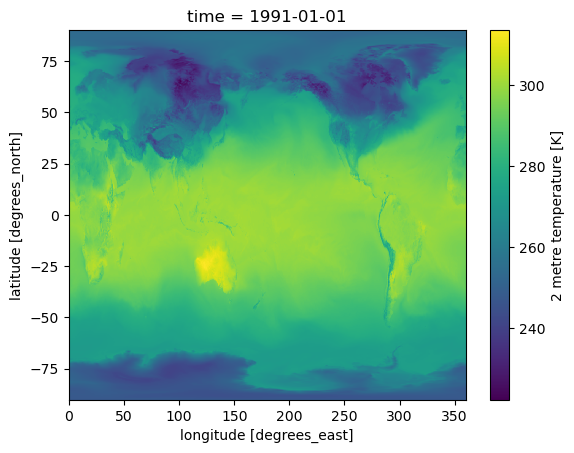

In [63]:
%%time
tas_obs_init.isel(time=0).plot()

### Perform Bias Correction

In [42]:
init_means_ds = xr.open_zarr(mean_path + 'cesm2_'+ init_year0 + '_' + init_year1+ '_means.zarr')
init_means    = init_means_ds.TREFHTMX
init_means

<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, day: 365)> Size: 81MB
dask.array<open_dataset-TREFHTMX, shape=(192, 288, 365), dtype=float32, chunksize=(192, 288, 365), chunktype=numpy.ndarray>
Coordinates:
  * day      (day) int64 3kB 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

In [43]:
final_means  = xr.open_zarr(mean_path  + 'cesm2_'+ final_year0 + '_' + final_year1+ '_means.zarr').TREFHTMX
init_stdevs  = xr.open_zarr(stdev_path + 'cesm2_'+ init_year0 + '_' + init_year1+ '_stdevs.zarr').TREFHTMX
final_stdevs = xr.open_zarr(stdev_path + 'cesm2_'+ final_year0 + '_' + final_year1+ '_stdevs.zarr').TREFHTMX

In [44]:
#Create output grid
ds_out = xr.Dataset(
    coords={
        'latitude': tas_obs_init.coords['latitude'],
        'longitude': tas_obs_init.coords['longitude']
    }
)
ds_out = ds_out.rename({'latitude':'lat','longitude':'lon'})
ds_out

<xarray.Dataset> Size: 17kB
Dimensions:  (lat: 721, lon: 1440)
Coordinates:
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Data variables:
    *empty*

In [45]:
tas_obs_initial    = to_daily(tas_obs_init)
tas_obs_initial    = tas_obs_initial.rename({'latitude':'lat','longitude':'lon'})
tas_obs_initial    = tas_obs_initial.chunk({'lat':139,'lon':544,'year':3,'day':90})
tas_obs_initial 

<xarray.DataArray 'VAR_2T' (lat: 721, lon: 1440, year: 30, day: 366)> Size: 46GB
dask.array<rechunk-merge, shape=(721, 1440, 30, 366), dtype=float32, chunksize=(139, 544, 3, 90), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 240B 1991 1992 1993 1994 1995 ... 2017 2018 2019 2020
  * day      (day) int64 3kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365 366
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Attributes: (12/14)
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    167
    grid_specification:                                 0.25 degree x 0.25 de...
    long_name:                                          2 metre temperature
    maximum_value:                                      320.42938232421875
    ...                                                 ...
    rda_dataset:                                        ds633.0
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    short_name:                                         2t
    units:                                              K

In [46]:
# %%time
# tas_obs_initial.to_dataset().to_zarr(zarr_path + "e5_tas2m_initial_1991_2020.zarr",mode='w')

In [47]:
tas_obs_initial = xr.open_zarr(zarr_path + "e5_tas2m_initial_1991_2020.zarr").VAR_2T

In [48]:
%%time 
regridder = xe.Regridder(init_means_ds, ds_out, "bilinear")
regridder

CPU times: user 15.7 s, sys: 1.21 s, total: 16.9 s
Wall time: 18.8 s


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_192x288_721x1440.nc 
Reuse pre-computed weights? False 
Input grid shape:           (192, 288) 
Output grid shape:          (721, 1440) 
Periodic in longitude?      False

In [49]:
init_means_regrid = regridder(init_means, keep_attrs=True)
init_means_regrid

<xarray.DataArray 'TREFHTMX' (day: 365, lat: 721, lon: 1440)> Size: 2GB
dask.array<astype, shape=(365, 721, 1440), dtype=float32, chunksize=(365, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * day      (day) int64 3kB 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Attributes:
    regrid_method:  bilinear

In [50]:
%%time
# Regrid other variables
init_stdevs_regrid  = regridder(init_stdevs, keep_attrs=True)
final_means_regrid  = regridder(final_means, keep_attrs=True)
final_stdevs_regrid = regridder(final_stdevs, keep_attrs=True)

CPU times: user 975 ms, sys: 56.8 ms, total: 1.03 s
Wall time: 1.23 s


In [51]:
# %%time
# #Save regridded data
# init_means_regrid.to_dataset().to_zarr(mean_path + 'cesm2_'+ init_year0 + '_' + init_year1+ '_means_regridded.zarr',mode='w')
# init_stdevs_regrid.to_dataset().to_zarr(stdev_path + 'cesm2_'+ init_year0 + '_' + init_year1+ '_stdevs_regridded.zarr',mode='w') 
# final_means_regrid.to_dataset().to_zarr(mean_path + 'cesm2_'+ final_year0 + '_' + final_year1+ '_means_regridded.zarr',mode='w')
# final_stdevs_regrid.to_dataset().to_zarr(stdev_path + 'cesm2_'+ final_year0 + '_' + final_year1+ '_stdevs_regridded.zarr',mode='w')

In [52]:
%%time
# Open regridded data
init_means_regrid  = xr.open_zarr(mean_path + 'cesm2_'+ init_year0 + '_' + init_year1+ '_means_regridded.zarr').TREFHTMX
init_stdevs_regrid = xr.open_zarr(stdev_path + 'cesm2_'+ init_year0 + '_' + init_year1+ '_stdevs_regridded.zarr').TREFHTMX
final_means_regrid  = xr.open_zarr(mean_path + 'cesm2_'+ final_year0 + '_' + final_year1+ '_means_regridded.zarr').TREFHTMX
final_stdevs_regrid = xr.open_zarr(stdev_path + 'cesm2_'+ final_year0 + '_' + final_year1+ '_stdevs_regridded.zarr').TREFHTMX

CPU times: user 13.2 ms, sys: 6.47 ms, total: 19.7 ms
Wall time: 173 ms


## Now, perform bias correction by only adjusting the first moment, i.e, mean and plot

In [53]:
tas_bc = tas_obs_initial  + (final_means_regrid - init_means_regrid)
tas_bc = tas_bc.chunk({'lat':139,'lon':544,'year':3,'day':90})
tas_bc

<xarray.DataArray (lat: 721, lon: 1440, year: 30, day: 365)> Size: 45GB
dask.array<add, shape=(721, 1440, 30, 365), dtype=float32, chunksize=(139, 544, 3, 90), chunktype=numpy.ndarray>
Coordinates:
  * day      (day) int64 3kB 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * year     (year) int64 240B 1991 1992 1993 1994 1995 ... 2017 2018 2019 2020

### Plot bias corrected temperature and CESM model's predictions for the End of the 21st century (2100)
- Since tas_bc are predictions for the years 2070-2100, we need to change the year coordinated
- We will then save the bias-corrected surface air temperatures (tas) to a zarr store.
- Finally, we will read from this zarr store and plot

In [54]:
# Change the year coordinate
tas_bc['year'] = tas_bc['year'] + 80
tas_bc         = tas_bc.rename('bias_corrected_tas')
tas_bc

<xarray.DataArray 'bias_corrected_tas' (lat: 721, lon: 1440, year: 30, day: 365)> Size: 45GB
dask.array<add, shape=(721, 1440, 30, 365), dtype=float32, chunksize=(139, 544, 3, 90), chunktype=numpy.ndarray>
Coordinates:
  * day      (day) int64 3kB 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * year     (year) int64 240B 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100

In [55]:
# %%time
# tas_bc.to_dataset().to_zarr(zarr_path + 'bias_corrected_tas_1991_2020.zarr',mode='w')

In [56]:
tas_bc = xr.open_zarr(zarr_path + 'bias_corrected_tas_1991_2020.zarr').bias_corrected_tas
tas_bc

<xarray.DataArray 'bias_corrected_tas' (lat: 721, lon: 1440, year: 30, day: 365)> Size: 45GB
dask.array<open_dataset-bias_corrected_tas, shape=(721, 1440, 30, 365), dtype=float32, chunksize=(139, 544, 3, 90), chunktype=numpy.ndarray>
Coordinates:
  * day      (day) int64 3kB 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * year     (year) int64 240B 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100

In [57]:
final_ensemble_means = xr.open_zarr(mean_path + 'cesm2_'+ final_year0 + '_' + final_year1 + '_ensemble_means.zarr').TREFHTMX
final_ensemble_means

<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, year: 30, day: 365)> Size: 2GB
dask.array<open_dataset-TREFHTMX, shape=(192, 288, 30, 365), dtype=float32, chunksize=(192, 288, 2, 365), chunktype=numpy.ndarray>
Coordinates:
  * day      (day) int64 3kB 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * year     (year) int64 240B 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100

CPU times: user 157 ms, sys: 17.7 ms, total: 175 ms
Wall time: 1.09 s


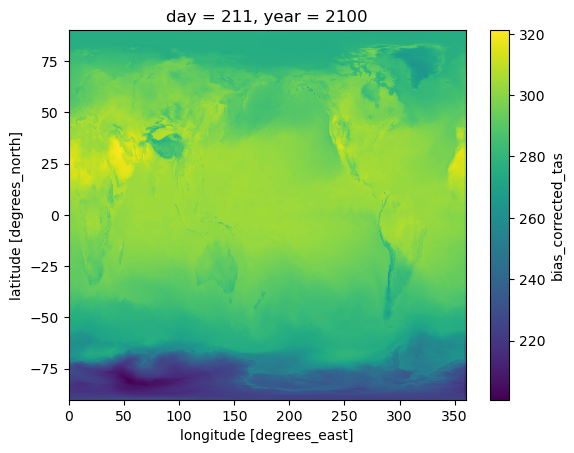

In [58]:
%%time
tas_bc.sel(year = 2100, day = 211).plot()

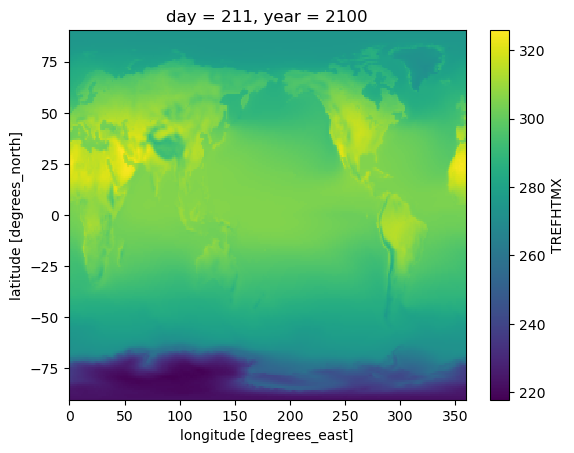

In [60]:
final_ensemble_means.sel(year = 2100, day = 211).plot()

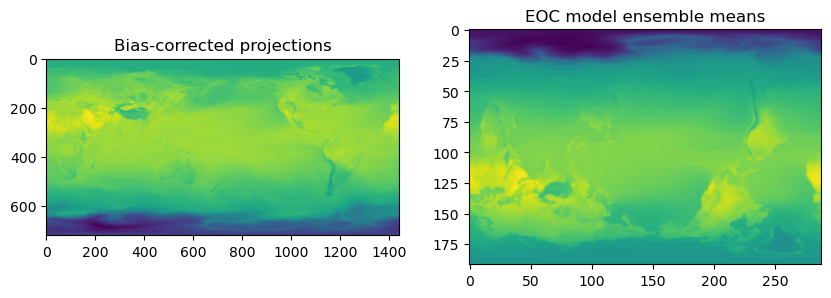

CPU times: user 295 ms, sys: 28.7 ms, total: 324 ms
Wall time: 1.56 s


In [59]:
%%time
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first array
axs[0].imshow(tas_bc.sel(year = 2100, day = 211))
axs[0].set_title('Bias-corrected projections')

# Plot the second array
axs[1].imshow(final_ensemble_means.sel(year = 2100, day = 211))
axs[1].set_title('EOC model ensemble means')

# Display the plots
plt.show()

### Calculate GMST 

In [ ]:
# GMST function ###
# calculate global means

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time','member_id'}
    return (ds * weight).mean(other_dims)

#### Now compute (spatially weighted) Global Mean